In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

CPU times: user 1.07 s, sys: 173 ms, total: 1.24 s
Wall time: 1.77 s


In [2]:
CNN_feat = np.load("encoder_feat.npy")

In [3]:
%%time
Linkage = linkage(CNN_feat[:10000], method="ward")

CPU times: user 16.5 s, sys: 492 ms, total: 17 s
Wall time: 17 s


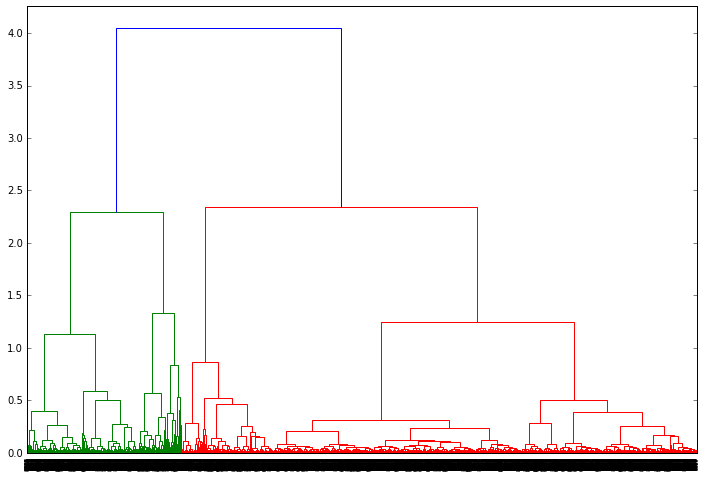

In [4]:
plt.figure(figsize=(12, 8))
dn = dendrogram(Linkage)
plt.show()

In [5]:
clusters = fcluster(Linkage, 1.5, criterion='distance')
print(clusters)

[1 4 4 ... 4 4 4]


In [6]:
print(np.unique(clusters))

[1 2 3 4]


In [7]:
%%time
class Waveform():
    
    def __init__(self, path=None):
        if path is None:
            raise ValueError("Insert file path!")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        
        label = np.load("first_label.npy")
        
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]

        self.waveform = normalize(pmtall,axis=1,norm="l2")
#         self.waveform = waveform_n[label==1]
        
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]

dataset = Waveform(path="Run9goodDataQ_dualgate.root")

CPU times: user 40.3 s, sys: 2.72 s, total: 43 s
Wall time: 43.2 s


In [31]:
%%time
ploter = dataset[:len(clusters)]
print(len(ploter))
ploter_1 = ploter[clusters==4]
print(len(ploter_1))


10000
6311
CPU times: user 465 ms, sys: 37 ms, total: 502 ms
Wall time: 499 ms


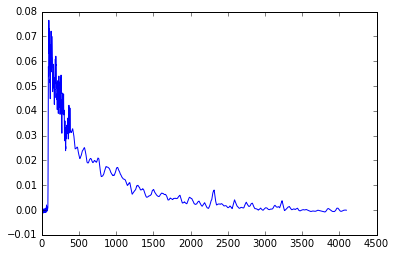

In [36]:
plt.figure(figsize=(6, 4))
plt.plot(ploter_1[np.random.randint(len(ploter_1))])
plt.show()

In [ ]:
no_classes = 3
dataset = Waveform(path="Run9goodDataQ_dualgate.root")

BATCH_SIZE = 3000
data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=3) 

In [ ]:
print(len(dataset))
n_batches = int(len(dataset)/BATCH_SIZE) 
print(n_batches)
del dataset

In [ ]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self,batch_size):
        super(Autoencoder, self).__init__()
        self.batch_size = batch_size
        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=8, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 16, kernel_size=8, stride=4, padding=4)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 16, kernel_size=8, stride=4, padding=4)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(16, 32, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
print("Autoencoder")

GEN = Autoencoder(BATCH_SIZE)
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

In [ ]:
GEN.load_state_dict(torch.load("GEN_WEIGHT_quarter.pkl"))

In [ ]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

In [ ]:
%%time
label = []

try:
    for batch_number, waveform in enumerate(data_loader):
        batch_size = waveform.size()[0]
#         label = label.detach().numpy()
        
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        feat = GEN(waveform_in)
        features = GEN.encoder(waveform_in)
        
        encoder_feat = np.reshape(features[0].detach().numpy(),(batch_size,-1))
        print(encoder_feat.shape)
        Z = linkage(encoder_feat, method="ward")
#         print(Z.shape)
#         print(Z)
#         fig = plt.figure(figsize=(12, 8))
#         dn = dendrogram(Z)
#         plt.title("{}".format(batch_number))
#         plt.show()
        
        clusters = fcluster(Z, 1.5, criterion='distance')
#         print(clusters.shape)
        print(clusters)
        print(np.unique(clusters))
        label = np.append(label,clusters)
        
        
#         for i, waveform_out in enumerate(feat[0]):
            
#             plt.figure()
#             plt.plot(waveform[i])
#             plt.show()

        

except KeyboardInterrupt:
    print('Training ended early.')

# Save output, shuffle=False, use thisoutput to mod dataset

In [ ]:
label = label.astype(int)
print(label)
np.save("first_label", label)